In [1]:
import numpy as np
from rubin_sim.maf import BaseMetric

import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import rubin_sim.maf as maf
import rubin_sim.utils as rsUtils
from rubin_sim.data import get_baseline
import os
import pandas as pd

In [2]:
baseline_file = get_baseline()
name = os.path.basename(baseline_file).replace('.db','')
out_dir = 'temp'
results_db = maf.db.ResultsDb(out_dir=out_dir)


In [3]:
# healpix resolution. Turing down a little to speed things up
nside = 64

bundle_list = []
time_points = np.arange(0,3652+365.25, 365.25)


for filtername in 'ugrizy':
    metric = maf.AccumulateM5Metric(time_points)
    # only use given filter. Toss out short visits and ToO visits
    sql = "filter='%s' and visitexposuretime > 17 and scheduler_note not like '%%ToO%%'" % filtername
    slicer = maf.slicers.HealpixSlicer(nside=nside)
    bundle_list.append(maf.MetricBundle(metric, slicer, sql, run_name=name))


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [4]:
bd = maf.metricBundles.make_bundles_dict_from_list(bundle_list)
bg = maf.metricBundles.MetricBundleGroup(bd, baseline_file, out_dir=out_dir, results_db=results_db)
bg.run_all()

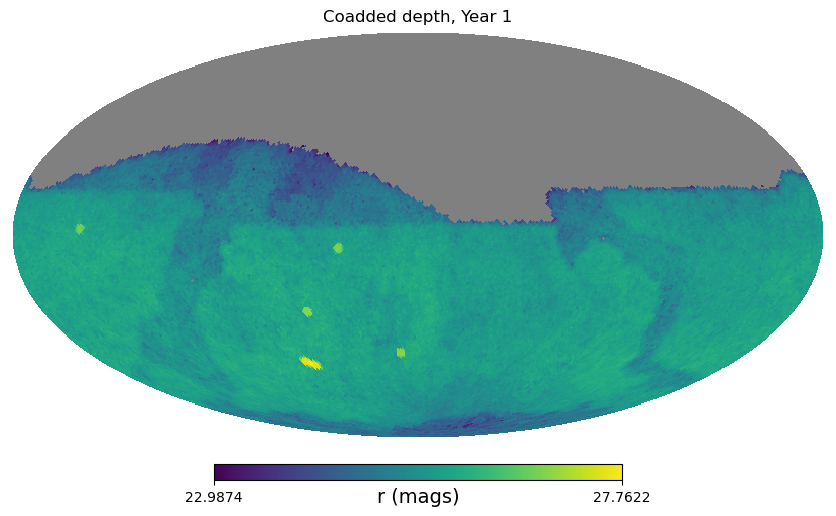

In [5]:
# Now we have the coaded depth maps at 10 time steps. 
i = 0
hp.mollview(bd['baseline_v5_0_0_10yrs_AccumulateM5Metric_r_and_visitexposuretime_gt_17_and_scheduler_note_not_like_ToO_HEAL'].metric_values[:,i], title="Coadded depth, Year %i" % (i+1),
           unit="r (mags)")

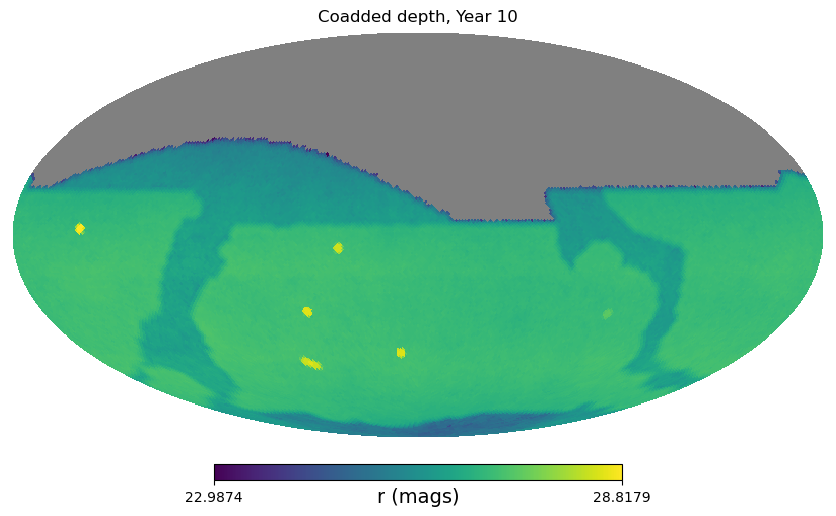

In [6]:
i=9
hp.mollview(bd['baseline_v5_0_0_10yrs_AccumulateM5Metric_r_and_visitexposuretime_gt_17_and_scheduler_note_not_like_ToO_HEAL'].metric_values[:,i], title="Coadded depth, Year %i" % (i+1),
           unit="r (mags)")

In [7]:
# loop over filter and times to make a table of the median values
df = pd.DataFrame()
for filtername in 'ugrizy':
    medians = []
    maps = bd["baseline_v5_0_0_10yrs_AccumulateM5Metric_%s_and_visitexposuretime_gt_17_and_scheduler_note_not_like_ToO_HEAL" % filtername].metric_values
    # doing a stupid loop because masked values are a pain
    for i in np.arange(10):
        medians.append(np.median(maps[:,i].data[~maps[:,i].mask]))
    df[filtername] = medians
    

In [8]:
print("Median coadded depth per year per filter")
df

Median coadded depth per year per filter


,u,g,r,i,z,y
0,24.436665,25.595164,25.590618,25.165416,24.469541,23.555287
1,24.646440,25.966589,26.027049,25.533690,24.820797,23.913393
2,24.837169,26.149931,26.262380,25.759096,25.073506,24.159141
3,24.982173,26.253893,26.389422,25.880979,25.217950,24.292825
4,25.120954,26.363006,26.502929,25.977474,25.328185,24.401512
5,25.229923,26.446936,26.592475,26.072874,25.425273,24.486161
6,25.325021,26.537674,26.677716,26.162273,25.518301,24.571837
7,25.392532,26.613355,26.743811,26.224071,25.578949,24.633596
8,25.460596,26.685609,26.814610,26.292370,25.648957,24.700365
9,25.531120,26.761429,26.883786,26.365241,25.718832,24.757024


In [9]:
# say we want to do a single point:
bundle_list = []
time_points = np.arange(0,3652+365.25, 365.25)

# My favorite test sample point
ra = 0.
dec = -20.

for filtername in 'ugrizy':
    metric = maf.AccumulateM5Metric(time_points)
    # only use given filter. Toss out short visits and ToO visits
    sql = "filter='%s' and visitexposuretime > 17 and scheduler_note not like '%%ToO%%'" % filtername
    slicer = maf.slicers.UserPointsSlicer(ra=ra, dec=dec)
    bundle_list.append(maf.MetricBundle(metric, slicer, sql, run_name=name))


In [10]:
bd = maf.metricBundles.make_bundles_dict_from_list(bundle_list)
bg = maf.metricBundles.MetricBundleGroup(bd, baseline_file, out_dir=out_dir, results_db=results_db)
bg.run_all()

In [11]:
# load the results into a dataframe for pretty printing
df = pd.DataFrame()
for filtername,key in zip('ugrizy', bd):
    df[filtername] = np.concatenate([bd[key].metric_values.data.ravel()])


In [12]:
# depth at our sample point per year per filter. 
print("Coadded depths per year at ra=%.2f,dec=%.2f" % (ra, dec))
df

Coadded depths per year at ra=0.00,dec=-20.00


,u,g,r,i,z,y
0,24.630673,25.517678,25.605867,25.188831,24.550885,23.674549
1,24.653271,25.546879,25.760022,25.465563,24.758386,23.841929
2,24.826745,25.994370,26.119767,25.775449,25.062944,24.163256
3,25.102880,26.300929,26.315380,25.900961,25.210307,24.335542
4,25.172363,26.300929,26.384984,25.951189,25.275333,24.335542
5,25.291941,26.381871,26.518174,26.055331,25.388310,24.456312
6,25.395342,26.496284,26.649285,26.170345,25.516878,24.582453
7,25.414903,26.496284,26.683909,26.208418,25.523356,24.619064
8,25.508771,26.607208,26.781244,26.290978,25.571190,24.722801
9,25.661911,26.716320,26.874021,26.430145,25.682658,24.811402
